In [2]:
from __future__ import print_function
import argparse
import pickle

import numpy as np
import torch
from captum.attr import IntegratedGradients

import cbig.osama2024.misc as misc

f:\Professional\Thesis\RNN-AD\RNN_py3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### predict functions

In [69]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--checkpoint', required=True)
    parser.add_argument('--data', required=True)
    parser.add_argument('--out', '-o', required=True)

    return parser.parse_args()


def predict_subject(model, cat_seq, value_seq, time_seq):
    """
    Predict Alzheimer’s disease progression for a subject
    Args:
        model: trained pytorch model
        cat_seq: sequence of diagnosis [nb_input_timpoints, nb_classes]
        value_seq: sequence of other features [nb_input_timpoints, nb_features]
        time_seq: months from baseline [nb_output_timpoints, nb_features]
    nb_input_timpoints <= nb_output_timpoints
    Returns:
        out_cat: predicted diagnosis
        out_val: predicted features
    """
    in_val = np.full((len(time_seq), ) + value_seq.shape[1:], np.nan)
    in_val[:len(value_seq)] = value_seq

    in_cat = np.full((len(time_seq), ) + cat_seq.shape[1:], np.nan)
    in_cat[:len(cat_seq)] = cat_seq

    with torch.no_grad():
        out_cat, out_val = model(in_cat, in_val)
    out_cat = out_cat.cpu().numpy()
    out_val = out_val.cpu().numpy()

    assert out_cat.shape[1] == out_val.shape[1] == 1

    return out_cat, out_val


def predict(model, dataset, pred_start, duration, baseline):
    """
    Predict Alzheimer’s disease progression using a trained model
    Args:
        model: trained pytorch model
        dataset: test data
        pred_start (dictionary): the date at which prediction begins
        duration (dictionary): how many months into the future to predict
        baseline (dictionary): the baseline date
    Returns:
        dictionary which contains the following key/value pairs:
            subjects: list of subject IDs
            DX: list of diagnosis prediction for each subject
            ADAS13: list of ADAS13 prediction for each subject
            Ventricles: list of ventricular volume prediction for each subject
    """
    model.eval()
    ret = {'subjects': dataset.subjects}
    ret['DX'] = []  # 1. likelihood of NL, MCI, and Dementia
    ret['ADAS13'] = []  # 2. (best guess, upper and lower bounds on 50% CI)
    ret['Ventricles'] = []  # 3. (best guess, upper and lower bounds on 50% CI)
    ret['dates'] = misc.make_date_col(
        [pred_start[s] for s in dataset.subjects], duration)

    col = ['ADAS13', 'Ventricles', 'ICV']
    indices = misc.get_index(list(dataset.value_fields()), col)
    mean = model.mean[col].values.reshape(1, -1)
    stds = model.stds[col].values.reshape(1, -1)

    for i in range(len(dataset)):  # Iterate over subjects using indices
        data = dataset[i]  # Access data using index
        # print the columns
        #print(data.keys())
        rid = data['rid']
        all_tp = data['tp'].squeeze(axis=1)
        start = misc.month_between(pred_start[rid], baseline[rid])
        assert np.all(all_tp == np.arange(len(all_tp)))
        mask = all_tp < start
        itime = np.arange(start + duration)
        icat = np.asarray(
            [misc.to_categorical(c, 3) for c in data['cat'][mask]])
        ival = data['val'][:, None, :][mask]

        ocat, oval = predict_subject(model, icat, ival, itime)
        oval = oval[-duration:, 0, indices] * stds + mean

        ret['DX'].append(ocat[-duration:, 0, :])
        ret['ADAS13'].append(misc.add_ci_col(oval[:, 0], 1, 0, 85))
        ret['Ventricles'].append(
            misc.add_ci_col(oval[:, 1] / oval[:, 2], 5e-4, 0, 1))

    return ret

### IG

In [3]:
checkpoint_path = 'output/model.pt'
data_path = 'output/val.pkl'

device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load(checkpoint_path)
model.to(device)

with open(data_path, 'rb') as fhandler:
    data = pickle.load(fhandler)

In [4]:
integrated_gradients = IntegratedGradients(model)

In [5]:
test_data = data['test']
pred_start = data['pred_start']
duration = data['duration']
baseline = data['baseline']

### IG for a specific duration and target class (CN:0, MCI:1, AD:2)

In [ ]:


duration = 20
target_index_2 = 0

model.eval()
ret = {'subjects': test_data.subjects}
ret['DX'] = []  # 1. likelihood of NL, MCI, and Dementia
ret['ADAS13'] = []  # 2. (best guess, upper and lower bounds on 50% CI)
ret['Ventricles'] = []  # 3. (best guess, upper and lower bounds on 50% CI)
ret['dates'] = misc.make_date_col(
    [pred_start[s] for s in test_data.subjects], duration)

col = ['ADAS13', 'Ventricles', 'ICV']
indices = misc.get_index(list(test_data.value_fields()), col)
mean = model.mean[col].values.reshape(1, -1)
stds = model.stds[col].values.reshape(1, -1)

attributions = {}
    
for i in range(len(test_data)):
    data_entry = test_data[i]
    rid = data_entry['rid']
    all_tp = data_entry['tp'].squeeze(axis=1)
    start = misc.month_between(pred_start[rid], baseline[rid])
    assert np.all(all_tp == np.arange(len(all_tp)))
    mask = all_tp < start
    itime = np.arange(start + duration)
    icat = np.asarray(
        [misc.to_categorical(c, 3) for c in data_entry['cat'][mask]])
    ival = data_entry['val'][:, None, :][mask]
    
    in_val = np.full((len(itime), ) + ival.shape[1:], np.nan)
    in_val[:len(ival)] = ival
    
    in_cat = np.full((len(itime), ) + icat.shape[1:], np.nan)
    in_cat[:len(icat)] = icat
    
    input_val = torch.tensor(in_val, dtype=torch.float32).to(device)
    input_cat = torch.tensor(in_cat, dtype=torch.float32).to(device)
    # input_val = in_val
    # input_cat = in_cat
    
    # target = (0,0,0,0)
    # # convert to tensor
    # target_tensor = torch.tensor(target, dtype=torch.float32).to(device)
    
    attr_cat = integrated_gradients.attribute(
        inputs=(input_cat, input_val), 
        baselines=None,  # You can provide baselines if needed
        target=(0,target_index_2)  # You can specify the target output index if needed
    )
    
    # Save attributions
    attributions[rid] = {
        'cat': attr_cat
    }
    
    # ocat, oval = predict_subject(model, icat, ival, itime)


### IG for durations 40,60,80

In [5]:
durations = [20, 40, 60, 80]
categories = [0, 1, 2]

for duration in durations:
    print(f"Duration: {duration}")
    for c in categories:
        print(f"Category: {c}")
        target_index_2 = c
        
        model.eval()
        ret = {'subjects': test_data.subjects}
        ret['DX'] = []  # 1. likelihood of NL, MCI, and Dementia
        ret['ADAS13'] = []  # 2. (best guess, upper and lower bounds on 50% CI)
        ret['Ventricles'] = []  # 3. (best guess, upper and lower bounds on 50% CI)
        ret['dates'] = misc.make_date_col(
            [pred_start[s] for s in test_data.subjects], duration)

        col = ['ADAS13', 'Ventricles', 'ICV']
        indices = misc.get_index(list(test_data.value_fields()), col)
        mean = model.mean[col].values.reshape(1, -1)
        stds = model.stds[col].values.reshape(1, -1)
        
        
        attributions = {}
    
        for i in range(len(test_data)):
            data_entry = test_data[i]
            rid = data_entry['rid']
            all_tp = data_entry['tp'].squeeze(axis=1)
            start = misc.month_between(pred_start[rid], baseline[rid])
            assert np.all(all_tp == np.arange(len(all_tp)))
            mask = all_tp < start
            itime = np.arange(start + duration)
            icat = np.asarray(
                [misc.to_categorical(c, 3) for c in data_entry['cat'][mask]])
            ival = data_entry['val'][:, None, :][mask]
            
            in_val = np.full((len(itime), ) + ival.shape[1:], np.nan)
            in_val[:len(ival)] = ival
            
            in_cat = np.full((len(itime), ) + icat.shape[1:], np.nan)
            in_cat[:len(icat)] = icat
            
            input_val = torch.tensor(in_val, dtype=torch.float32).to(device)
            input_cat = torch.tensor(in_cat, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                out_cat = model(input_cat, input_val)
        
            out_cat = out_cat.cpu().numpy()
            ret['DX'].append(out_cat[-duration:, 0, :])
            
            # target = (0,0,0,0)
            # # convert to tensor
            # target_tensor = torch.tensor(target, dtype=torch.float32).to(device)
            
            attr_cat = integrated_gradients.attribute(
                inputs=(input_cat, input_val), 
                baselines=None,  # You can provide baselines if needed
                target=(0,target_index_2)  # You can specify the target output index if needed
            )
            
            # Save attributions
            attributions[rid] = {
                'cat': attr_cat
            }
            
            my_dict = attributions

        #save the attributions
        with open(f'MyData/attr2/attributions_{duration}_{target_index_2}.pickle', 'wb') as pickle_file:
            pickle.dump(my_dict, pickle_file)
        
        #save the ret
        with open(f'MyData/ret2/ret_{duration}_{target_index_2}.pickle', 'wb') as pickle_file:
            pickle.dump(ret, pickle_file)
            
        
        

Duration: 20
Category: 0
Category: 1
Category: 2
Duration: 40
Category: 0
Category: 1
Category: 2
Duration: 60
Category: 0
Category: 1
Category: 2
Duration: 80
Category: 0
Category: 1
Category: 2


### Load attributions

In [6]:
import pickle 

loaded_duration = 80
loaded_target_index_2 = 2

# load ret
with open(f'MyData/ret2/ret_{loaded_duration}_{loaded_target_index_2}.pickle', 'rb') as pickle_file:
    ret = pickle.load(pickle_file)
    
with open(f'MyData/attr2/attributions_{loaded_duration}_{loaded_target_index_2}.pickle', 'rb') as pickle_file:
    my_dict = pickle.load(pickle_file)
    
attributions = my_dict

### Grouping

Here we divide the patients according to their final predicted classes. So there can not be more than 3 divisions. At the same time attributions are divided into 3 groups as well

In [7]:
def divide_data_by_max_probability(ret, attributions, day):
    # Initialize
    divided_ret = {i: [] for i in range(ret['DX'][0].shape[1])}
    divided_attributions = {i: [] for i in range(ret['DX'][0].shape[1])}

    for patient_index in range(len(ret['DX'])):
        # Get the diagnosis probabilities for the specified day for the current patient
        probabilities = ret['DX'][patient_index][day - 1]

        # Find the index of the diagnosis class with the maximum probability for this day
        max_index = np.argmax(probabilities)

        # Append the current patient's data to the corresponding divided part for ret
        divided_ret[max_index].append({
            'patient_index': patient_index,
            'diagnosis_probabilities': probabilities
        })

        # Append the corresponding attribution data
        attribution_key = list(attributions.keys())[patient_index]
        divided_attributions[max_index].append({
            'patient_index': patient_index,
            'attribution_data': attributions[attribution_key]
        })

    return divided_ret, divided_attributions

# Example usage
day = 40
divided_ret, divided_attributions = divide_data_by_max_probability(ret, attributions, day)

# Print the lengths of divided parts for ret
for class_index, data_list in divided_ret.items():
    print(f"Class {class_index}: {len(data_list)} patients")

# Print the lengths of divided parts for attributions
for class_index, data_list in divided_attributions.items():
    print(f"Class {class_index}: {len(data_list)} attributions")


Class 0: 57 patients
Class 1: 47 patients
Class 2: 55 patients
Class 0: 57 attributions
Class 1: 47 attributions
Class 2: 55 attributions


In [8]:
print(divided_attributions[1][0]['attribution_data']['cat'][1][0])

# convert to numpy
np_attributions = np.array(divided_attributions[1][0]['attribution_data']['cat'][1][0][0])


tensor([[-0.0712, -0.0024,  0.0354, -0.0956,  0.0538,  0.1127,  0.0057,  0.1312,
         -0.0000, -0.0280,  0.0181,  0.0005,  0.0226,  0.0201, -0.0083, -0.0011,
          0.0024,  0.0000, -0.0000, -0.0354, -0.0063,  0.0215]],
       dtype=torch.float64)


In [9]:
np_attributions.shape

(22,)

### Plot attributions
parameters:
* feature_index = which feature to focus on
* num_patient = count of patients. -1 means all from that group
* class_index = select the attribution group. 

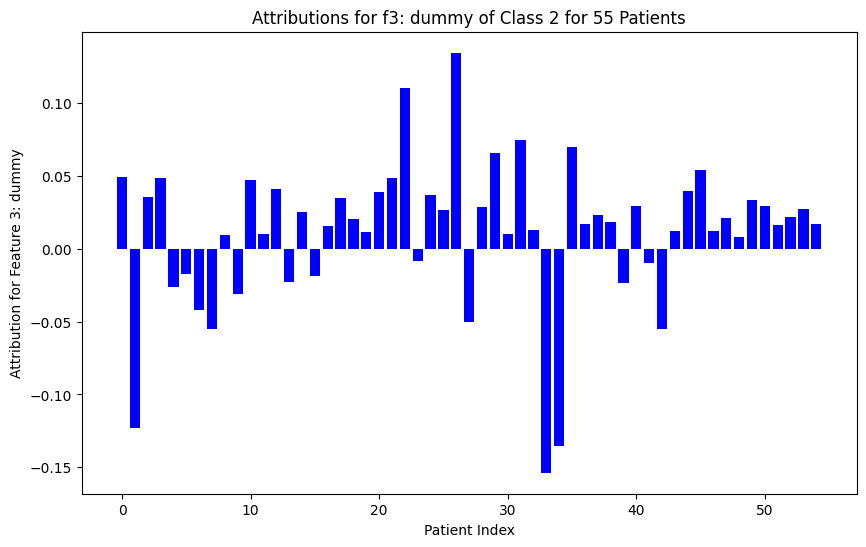

In [10]:
import matplotlib.pyplot as plt

def plot_feature_attributions(feature_index, num_patients, class_index, 
                              divided_attributions, feature_name, isShow=True):
    # Extract attributions for the specified class index and feature index
    attributions = divided_attributions[class_index]

    if num_patients == -1:
        num_patients = len(attributions)

    # Extract the feature attributions for the specified feature index
    feature_attributions = [attribution['attribution_data']['cat'][1][0][0][feature_index].numpy() for attribution in attributions[:num_patients]]

    feature_mean = np.mean(feature_attributions)
    feature_std = np.std(feature_attributions)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    for i, attribution in enumerate(feature_attributions):
        plt.bar(i, attribution, color='blue')
    plt.xlabel('Patient Index')
    plt.ylabel(f'Attribution for Feature {feature_index}: {feature_name}')
    plt.title(f'Attributions for f{feature_index}: {feature_name} of Class {class_index} for {num_patients} Patients')
    
    if isShow:
        plt.show()
    
    plt.savefig(f'MyData/plots/{loaded_duration}/target_{loaded_target_index_2}/attr_C{class_index}_f{feature_index}.png')
    
    return feature_mean, feature_std

# Example usage
feature_index = 3  # Change this to the desired feature index
num_patients = -1  # Change this to -1 to include all patients, otherwise specify a number
class_index = 2  # Change this to the desired class index

feature_mean, feature_std = \
    plot_feature_attributions(feature_index, num_patients, \
        class_index, divided_attributions, "dummy", False)


### Combined attempt

In [1]:
import matplotlib.pyplot as plt

def plot_feature_attributions2(feature_index, num_patients, class_index, 
                               attributions, feature_name, isShow=True):
    # Extract attributions for the specified class index and feature index
    attributions0 = divided_attributions[0]
    attributions1 = divided_attributions[1]
    attributions2 = divided_attributions[2]
    
    #concat 3 lists
    attributions = attributions0 + attributions1 + attributions2

    if num_patients == -1:
        num_patients = len(attributions)

    # Extract the feature attributions for the specified feature index
    feature_attributions = [attribution['attribution_data']['cat'][1][0][0][feature_index].numpy() for attribution in attributions[:num_patients]]

    feature_mean = np.mean(feature_attributions)
    feature_std = np.std(feature_attributions)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    for i, attribution in enumerate(feature_attributions):
        plt.bar(i, attribution, color='blue')
    plt.xlabel('Patient Index')
    plt.ylabel(f'Attribution for Feature {feature_index}: {feature_name}')
    plt.title(f'Attributions for f{feature_index}: {feature_name} of Class {class_index} for {num_patients} Patients')
    
    if isShow:
        plt.show()
        
    #save fig
    plt.savefig(f'MyData/plots/{loaded_duration}/target_{loaded_target_index_2}/attr_all_f{feature_index}.png')
    
    return feature_mean, feature_std

# Example usage
feature_index = 3  # Change this to the desired feature index
num_patients = -1  # Change this to -1 to include all patients, otherwise specify a number
class_index = 2  # Change this to the desired class index

feature_mean, feature_std = \
    plot_feature_attributions2(feature_index, num_patients, \
        class_index, divided_attributions, "dummy", False)

NameError: name 'divided_attributions' is not defined

### detailed analysis

In [ ]:
durations = [20, 40, 60, 80]
categories = [0, 1, 2]

for duration in durations:
    loaded_duration = duration
    for c in categories:
        print(f"Duration: {duration}")
        print(f"Category: {c}")
        target_index_2 = c
        loaded_target_index_2 = target_index_2
        
        #load attributions
        with open(f'MyData/attr2/attributions_{duration}_{target_index_2}.pickle', 'rb') as pickle_file:
            my_dict = pickle.load(pickle_file)
        
        #load ret
        with open(f'MyData/ret2/ret_{duration}_{target_index_2}.pickle', 'rb') as pickle_file:
            ret = pickle.load(pickle_file)
            
        #divide data
        divided_ret, divided_attributions = divide_data_by_max_probability(ret, my_dict, duration)
        
        for class_index, data_list in divided_ret.items():
            print(f"Class {class_index}: {len(data_list)} patients")
            
        for class_index, data_list in divided_attributions.items():
            print(f"Class {class_index}: {len(data_list)} attributions")
            
        mean_values_CN = []
        mean_values_MCI = []    
        mean_values_AD = []

        mean_values_all = []

        std_values_CN = []
        std_values_MCI = []
        std_values_AD = []

        std_values_all = []

        num_features = 22
        num_patients = -1
        
        #list the feature names, means and stds
        feature_names = misc.load_feature('data/features')

        for i in range(0, num_features):
            feature_mean, feature_std = \
                plot_feature_attributions(i, num_patients, \
                    0, divided_attributions, feature_names[i], False)
            mean_values_CN.append(feature_mean)
            std_values_CN.append(feature_std)
            
            feature_mean, feature_std = \
                plot_feature_attributions(i, num_patients, \
                    1, divided_attributions, feature_names[i], False)
            mean_values_MCI.append(feature_mean)
            std_values_MCI.append(feature_std)
            
            feature_mean, feature_std = \
                plot_feature_attributions(i, num_patients, \
                    2, divided_attributions, feature_names[i], False)
            mean_values_AD.append(feature_mean)
            std_values_AD.append(feature_std)
            
            feature_mean, feature_std = \
                plot_feature_attributions2(i, num_patients, \
                    0, divided_attributions, feature_names[i], False)
            mean_values_all.append(feature_mean)
            std_values_all.append(feature_std)
            
        
        # save the feature names, means and stds as a csv
        import csv

        with open(f'MyData/plots/{loaded_duration}/target_{loaded_target_index_2}/feature_attributions.csv', mode='w') as file:
            writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['Feature Name', 'CN Mean', 'CN Std', 
                            'MCI Mean', 'MCI Std', 'AD Mean', 'AD Std', 'Combined Mean', 'Combined Std'])
            for i in range(0, num_features):
                writer.writerow([feature_names[i], mean_values_CN[i], std_values_CN[i], 
                                mean_values_MCI[i], std_values_MCI[i], mean_values_AD[i], 
                                std_values_AD[i], mean_values_all[i], std_values_all[i]])
                    

In [15]:
#list the feature names, means and stds
feature_names = misc.load_feature('data/features')
len(feature_names)

22

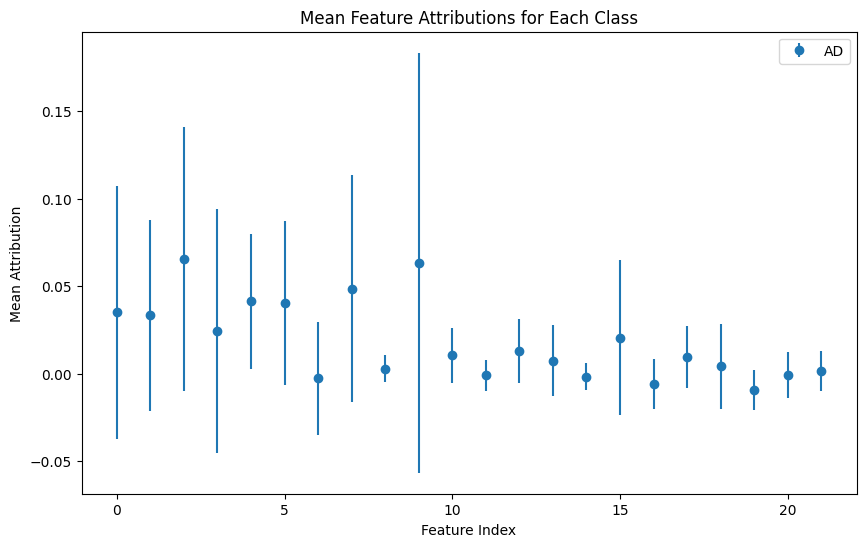

In [120]:
#plot the mean values
import matplotlib.pyplot as plt
import numpy as np

# data
x = np.arange(22)
y1 = mean_values_CN
y2 = mean_values_MCI
y3 = mean_values_AD

y4 = mean_values_all

std1 = std_values_CN
std2 = std_values_MCI
std3 = std_values_AD

std4 = std_values_all

# plot with error bars
plt.figure(figsize=(10, 6))

#plt.errorbar(x, y2, yerr=std2, fmt='o', label='MCI')
#plt.errorbar(x, y1, yerr=std1, fmt='o', label='CN')
plt.errorbar(x, y3, yerr=std3, fmt='o', label='AD')
#plt.errorbar(x, y4, yerr=std4, fmt='o', label='All')
plt.xlabel('Feature Index')
plt.ylabel('Mean Attribution')
plt.title('Mean Feature Attributions for Each Class')
plt.legend()
plt.show()


In [110]:
loaded_target_index_2

0

### saving the mean and std values in csv

In [121]:
#list the feature names, means and stds
feature_names = misc.load_features('data/features')

# save the feature names, means and stds as a csv
import csv

# create the csv if doesnt exits
# import os
# if not os.path.exists(f'MyData/plots/{loaded_duration}/target_{loaded_target_index_2}/feature_attributions.csv'):
#     print("nai")
#     os.makedirs(f'MyData/plots/{loaded_duration}/target_{loaded_target_index_2}/feature_attributions.csv')

with open(f'MyData/plots/{loaded_duration}/target_{loaded_target_index_2}/feature_attributions.csv', mode='w') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Feature Name', 'CN Mean', 'CN Std', 
                     'MCI Mean', 'MCI Std', 'AD Mean', 'AD Std', 'Combined Mean', 'Combined Std'])
    for i in range(0, num_features):
        writer.writerow([feature_names[i], mean_values_CN[i], std_values_CN[i], 
                         mean_values_MCI[i], std_values_MCI[i], mean_values_AD[i], 
                         std_values_AD[i], mean_values_all[i], std_values_all[i]])
        

In [35]:
#load the csv
import pandas as pd

loaded_csv_duration = 80
loaded_csv_target_index_2 = 2


df = pd.read_csv(f'MyData/plots/{loaded_csv_duration}/target_{loaded_csv_target_index_2}/feature_attributions.csv')
df.head()


# list the top 5 and bottom 5 features for each class only two related columns feature name and related mean
top_5_CN = df.nlargest(5, 'CN Mean')[['Feature Name', 'CN Mean']]
bottom_5_CN = df.nsmallest(5, 'CN Mean')[['Feature Name', 'CN Mean']]

top_5_MCI = df.nlargest(5, 'MCI Mean')[['Feature Name', 'MCI Mean']]
bottom_5_MCI = df.nsmallest(5, 'MCI Mean')[['Feature Name', 'MCI Mean']]

top_5_AD = df.nlargest(5, 'AD Mean')[['Feature Name', 'AD Mean']]
bottom_5_AD = df.nsmallest(5, 'AD Mean')[['Feature Name', 'AD Mean']]

top_5_all = df.nlargest(5, 'Combined Mean')[['Feature Name', 'Combined Mean']]
bottom_5_all = df.nsmallest(5, 'Combined Mean')[['Feature Name', 'Combined Mean']]


# print the feature and only their means for each class in a text file
with open(f'MyData/plots/{loaded_csv_duration}/target_{loaded_csv_target_index_2}/top_bottom_features.txt', 'w') as f:
    f.write("Top 5 CN Features\n")
    f.write(top_5_CN.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 CN Features\n")
    f.write(bottom_5_CN.to_string())
    f.write("\n\n")
    
    f.write("Top 5 MCI Features\n")
    f.write(top_5_MCI.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 MCI Features\n")
    f.write(bottom_5_MCI.to_string())
    f.write("\n\n")
    
    f.write("Top 5 AD Features\n")
    f.write(top_5_AD.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 AD Features\n")
    f.write(bottom_5_AD.to_string())
    f.write("\n\n")
    
    f.write("Top 5 All Features\n")
    f.write(top_5_all.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 All Features\n")
    f.write(bottom_5_all.to_string())
    f.write("\n\n")



In [9]:
# sort by specific column values

target_column = 'CN Mean'
df = df.sort_values(by=[target_column], ascending=False)
df

,Feature Name,CN Mean,CN Std,MCI Mean,MCI Std,AD Mean,AD Std,Combined Mean,Combined Std
0,CDRSB,0.131804,0.041333,0.017626,0.025774,-0.003607,0.004603,0.051379,0.065907
4,RAVLT_immediate,0.042023,0.042929,0.004243,0.011008,-0.003346,0.002147,0.015259,0.032759
9,FAQ,0.040125,0.010222,0.007263,0.008526,-0.003174,0.003358,0.015808,0.019927
2,ADAS13,0.029426,0.015279,0.004071,0.006515,-0.002010,0.001361,0.011197,0.016708
19,ABETA_UPENNBIOMK9_04_19_17,0.022144,0.039784,0.001115,0.011409,-0.001111,0.000905,0.007787,0.026598
1,ADAS11,0.018178,0.009388,0.002916,0.004333,-0.001261,0.001119,0.007066,0.010301
5,RAVLT_learning,0.011143,0.025196,0.002166,0.005394,-0.001476,0.001363,0.004286,0.016069
8,MOCA,0.009508,0.012663,0.001014,0.002436,-0.000207,0.000529,0.003622,0.008739
10,Entorhinal,0.007587,0.010120,0.001696,0.005529,-0.000813,0.000955,0.003055,0.007698
18,FDG,0.007284,0.010910,0.001909,0.004481,-0.000540,0.000780,0.003106,0.007696


In [146]:
df = df.sort_values(by=[target_column], ascending=True)
df

,Feature Name,CN Mean,CN Std,MCI Mean,MCI Std,AD Mean,AD Std,Combined Mean,Combined Std
9,FAQ,NaN,NaN,0.052298,0.063847,-0.070392,0.131400,0.016031,0.105402
2,ADAS13,NaN,NaN,0.010744,0.023819,-0.056371,0.054758,-0.009095,0.047158
0,CDRSB,NaN,NaN,0.034485,0.056518,-0.043007,0.083111,0.011578,0.074446
1,ADAS11,NaN,NaN,0.010079,0.014872,-0.029103,0.039646,-0.001503,0.030661
4,RAVLT_immediate,NaN,NaN,-0.001576,0.015098,-0.025331,0.026226,-0.008597,0.021941
7,RAVLT_perc_forgetting,NaN,NaN,-0.003381,0.022189,-0.024871,0.035294,-0.009733,0.028481
3,MMSE,NaN,NaN,0.026167,0.044368,-0.023246,0.067566,0.011561,0.056960
5,RAVLT_learning,NaN,NaN,-0.001524,0.013668,-0.018586,0.024872,-0.006568,0.019367
10,Entorhinal,NaN,NaN,0.000962,0.018497,-0.015247,0.022933,-0.003829,0.021240
13,ICV,NaN,NaN,-0.003125,0.015223,-0.012046,0.029644,-0.005762,0.020966


### Ranking of the feature attributions

In [ ]:
# sort the features by std deviation
import pandas as pd

# Create a dataframe
df = pd.DataFrame(list(zip(feature_names, mean_values_CN, std_values_CN, 
                           mean_values_MCI, std_values_MCI, mean_values_AD, 
                           std_values_AD, mean_values_all, std_values_all)), 
               columns =['Feature Name', 'CN Mean', 'CN Std', 'MCI Mean', 
                         'MCI Std', 'AD Mean', 'AD Std', 'Combined Mean', 'Combined Std'])

# Sort the dataframe by std deviation
df = df.sort_values(by='MCI Mean', ascending=True)

df


,Feature Name,CN Mean,CN Std,MCI Mean,MCI Std,AD Mean,AD Std,Combined Mean,Combined Std
9,FAQ,NaN,NaN,-2.441719e-03,0.002558,-0.003019,0.002934,-0.002612,0.002688
0,CDRSB,NaN,NaN,-1.785467e-03,0.001259,-0.002116,0.002317,-0.001883,0.001651
3,MMSE,NaN,NaN,-1.034284e-03,0.000834,-0.001204,0.001489,-0.001084,0.001073
2,ADAS13,NaN,NaN,-5.011546e-04,0.000488,-0.001571,0.001314,-0.000817,0.000957
1,ADAS11,NaN,NaN,-2.930287e-04,0.000330,-0.001445,0.001496,-0.000634,0.001007
18,FDG,NaN,NaN,-1.272887e-04,0.000283,-0.000243,0.000770,-0.000161,0.000484
13,ICV,NaN,NaN,-1.253471e-04,0.000603,-0.000502,0.001892,-0.000237,0.001159
10,Entorhinal,NaN,NaN,-1.101924e-04,0.000400,-0.000309,0.000455,-0.000169,0.000427
14,MidTemp,NaN,NaN,-1.064647e-04,0.000418,0.000121,0.000224,-0.000039,0.000386
11,Fusiform,NaN,NaN,-1.258037e-05,0.000139,0.000110,0.000201,0.000024,0.000169


In [ ]:
# Sort the dataframe by std deviation
df = df.sort_values(by='Combined Mean', ascending=False)

df

KeyError: 'Combined Mean'

In [ ]:
# sort the features by std deviation
import pandas as pd

# Create a dataframe
df = pd.DataFrame(list(zip(feature_names, mean_values_CN, std_values_CN, mean_values_MCI, std_values_MCI, mean_values_AD, std_values_AD)), 
               columns =['Feature Name', 'CN Mean', 'CN Std', 'MCI Mean', 'MCI Std', 'AD Mean', 'AD Std'])

# Sort the dataframe by std deviation
df = df.sort_values(by='AD Mean', ascending=True)

df


,Feature Name,CN Mean,CN Std,MCI Mean,MCI Std,AD Mean,AD Std
9,FAQ,NaN,NaN,-2.441719e-03,0.002558,-0.003019,0.002934
0,CDRSB,NaN,NaN,-1.785467e-03,0.001259,-0.002116,0.002317
4,RAVLT_immediate,NaN,NaN,2.910694e-04,0.000730,-0.002005,0.001163
5,RAVLT_learning,NaN,NaN,2.805122e-04,0.001061,-0.001725,0.001523
2,ADAS13,NaN,NaN,-5.011546e-04,0.000488,-0.001571,0.001314
1,ADAS11,NaN,NaN,-2.930287e-04,0.000330,-0.001445,0.001496
7,RAVLT_perc_forgetting,NaN,NaN,1.868886e-04,0.000656,-0.001278,0.001736
19,ABETA_UPENNBIOMK9_04_19_17,NaN,NaN,4.457639e-04,0.001910,-0.001236,0.001358
3,MMSE,NaN,NaN,-1.034284e-03,0.000834,-0.001204,0.001489
12,Hippocampus,NaN,NaN,2.589545e-04,0.000681,-0.000699,0.001072


In [ ]:
# Plot the mean and standard deviation of the feature attributions
print(f'Mean of the feature attributions: {feature_mean}')
print(f'Standard deviation of the feature attributions: {feature_std}')


Mean of the feature attributions: 0.01653003559434911
Standard deviation of the feature attributions: 0.02750965793172113


In [ ]:
import pickle

my_dict = attributions

with open(f'MyData/attributions_{duration}_{target_index_2}.pickle', 'wb') as pickle_file:
    pickle.dump(my_dict, pickle_file)


NameError: name 'target_index_2' is not defined

### Group Data

In [ ]:
#check type of first element of the tuple
len(attributions[7]['cat'][1])

21

In [ ]:
print(data['pred_start'])

{7: Timestamp('2005-11-06 00:00:00'), 15: Timestamp('2005-11-18 00:00:00'), 33: Timestamp('2006-01-09 00:00:00'), 35: Timestamp('2005-12-08 00:00:00'), 53: Timestamp('2005-12-29 00:00:00'), 56: Timestamp('2006-01-22 00:00:00'), 84: Timestamp('2006-02-24 00:00:00'), 86: Timestamp('2006-06-08 00:00:00'), 101: Timestamp('2006-02-04 00:00:00'), 125: Timestamp('2006-03-01 00:00:00'), 127: Timestamp('2006-03-24 00:00:00'), 176: Timestamp('2006-06-09 00:00:00'), 186: Timestamp('2006-04-06 00:00:00'), 256: Timestamp('2006-05-05 00:00:00'), 269: Timestamp('2006-05-12 00:00:00'), 282: Timestamp('2006-06-15 00:00:00'), 293: Timestamp('2006-04-28 00:00:00'), 314: Timestamp('2006-05-20 00:00:00'), 316: Timestamp('2006-05-24 00:00:00'), 326: Timestamp('2006-05-07 00:00:00'), 343: Timestamp('2006-05-25 00:00:00'), 403: Timestamp('2006-06-04 00:00:00'), 410: Timestamp('2006-05-26 00:00:00'), 417: Timestamp('2006-06-24 00:00:00'), 425: Timestamp('2006-07-19 00:00:00'), 442: Timestamp('2006-06-26 00:00:

### other attempts

In [ ]:
test_data = data['test']
pred_start = data['pred_start']
duration = data['duration']
baseline = data['baseline']

model.eval()
ret = {'subjects': test_data.subjects}
ret['DX'] = []  # 1. likelihood of NL, MCI, and Dementia
ret['ADAS13'] = []  # 2. (best guess, upper and lower bounds on 50% CI)
ret['Ventricles'] = []  # 3. (best guess, upper and lower bounds on 50% CI)
ret['dates'] = misc.make_date_col(
    [pred_start[s] for s in test_data.subjects], duration)

col = ['ADAS13', 'Ventricles', 'ICV']
indices = misc.get_index(list(test_data.value_fields()), col)
mean = model.mean[col].values.reshape(1, -1)
stds = model.stds[col].values.reshape(1, -1)

attr1 = {}

for i in range(len(test_data)):
    data_entry = test_data[i]
    rid = data_entry['rid']
    all_tp = data_entry['tp'].squeeze(axis=1)
    start = misc.month_between(pred_start[rid], baseline[rid])
    assert np.all(all_tp == np.arange(len(all_tp)))
    mask = all_tp < start
    itime = np.arange(start + duration)

    icat = np.asarray(
        [misc.to_categorical(c, 3) for c in data_entry['cat'][mask]])
    ival = data_entry['val'][:, None, :][mask]

    
    in_val = np.full((len(itime), ) + ival.shape[1:], np.nan)
    in_val[:len(ival)] = ival
    
    in_cat = np.full((len(itime), ) + icat.shape[1:], np.nan)
    in_cat[:len(icat)] = icat
    
    # print("in_val shape: ", in_val.shape)
    # print("in_val is: ", in_val)
    
    
    input_val = torch.tensor(in_val, dtype=torch.float32).to(device)
    input_cat = torch.tensor(in_cat, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        out_cat = model(input_cat, input_val)
        
    # print("shape of input_cat: ", input_cat.shape, " len: ", len(input_cat))
    # print("shape of input_val: ", input_val.shape, " len: ", len(input_val))
    # print("shape of out_cat: ", out_cat.shape, " len: ", len(out_cat))
    
    input_cat_first = input_cat[0].unsqueeze(0)

    # Concatenate the first row of input_cat with all of out_cat along the second dimension
    out_cat_extended = torch.cat((input_cat_first, out_cat), dim=0)

    #print("shape of out_cat_extended: ", out_cat_extended.shape)   
    #print(out_cat_extended)
    #attr[rid] = {'cat': []}
    
    
    attr_cat = integrated_gradients.attribute(
        inputs=(out_cat_extended, input_val), 
        baselines=None,  # You can provide baselines if needed
        target=(0,1)  # You can specify the target output index if needed
    )
    
    # Save attributions
    attr1[rid] = {
        'cat': attr_cat
    }
    
    # Loop through each time point for the current subject
    # for t in range(5):
    #     # Extract the input sequences for the current time point
    #     input_val_t = input_val[t].unsqueeze(0)
    #     input_cat_t = out_cat[t].unsqueeze(0)
        
    #     # print(input_val_t)
    #     # print(input_cat_t)
        
    #     # Calculate attributions for the current time point
    #     attr_cat_t = integrated_gradients.attribute(
    #         inputs=(input_cat_t, input_val_t), 
    #         baselines=None,  
    #         target=(0, 0)  
    #     )
        
    #     # Save attributions for the current time point
    #     attr[rid]['cat'].append(attr_cat_t)
    


IndexError: index 5 is out of bounds for dimension 1 with size 1

In [ ]:
print((attr[7]['cat'][1][1]))

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       dtype=torch.float64)


In [ ]:
#print(attr.keys())
print(attr)

{7: {'cat': (tensor([[[0.0000e+00, 0.0000e+00, 3.6882e-02]],

        [[6.7652e-03, 2.4888e-02, 2.9667e-02]],

        [[2.2196e-03, 1.1455e-02, 3.7001e-02]],

        [[8.9138e-04, 4.4283e-03, 3.7449e-02]],

        [[4.0057e-04, 1.6026e-03, 3.4730e-02]],

        [[1.9229e-04, 5.8261e-04, 3.0942e-02]],

        [[9.7384e-05, 2.2318e-04, 2.7021e-02]],

        [[5.2196e-05, 9.2806e-05, 2.3376e-02]],

        [[2.9905e-05, 4.2484e-05, 2.0165e-02]],

        [[1.8435e-05, 2.1411e-05, 1.7395e-02]],

        [[1.2191e-05, 1.1789e-05, 1.4993e-02]],

        [[8.5607e-06, 7.0288e-06, 1.2898e-02]],

        [[6.3186e-06, 4.5114e-06, 1.1118e-02]],

        [[4.8706e-06, 3.1070e-06, 9.6675e-03]],

        [[3.9032e-06, 2.2876e-06, 8.5081e-03]],

        [[3.2364e-06, 1.7890e-06, 7.5591e-03]],

        [[2.7609e-06, 1.4727e-06, 6.7476e-03]],

        [[2.4054e-06, 1.2649e-06, 6.0297e-03]],

        [[2.1209e-06, 1.1262e-06, 5.3890e-03]],

        [[1.8773e-06, 1.0360e-06, 4.8278e-03]],

       

### plotting


In [ ]:
print(len(attributions[7]))

1


In [ ]:
print(len(attributions.keys()))

159


In [ ]:
print(len(attributions[15]['cat'][0]))
print(attributions[15]['cat'][0][0])

21
tensor([[0.0045, 0.0000, -0.0000]], dtype=torch.float64)


In [ ]:
# print attribution for rid 7
print(attributions[35]['cat'])

#print dimension of the attribution
print(len(attributions[7]['cat']))

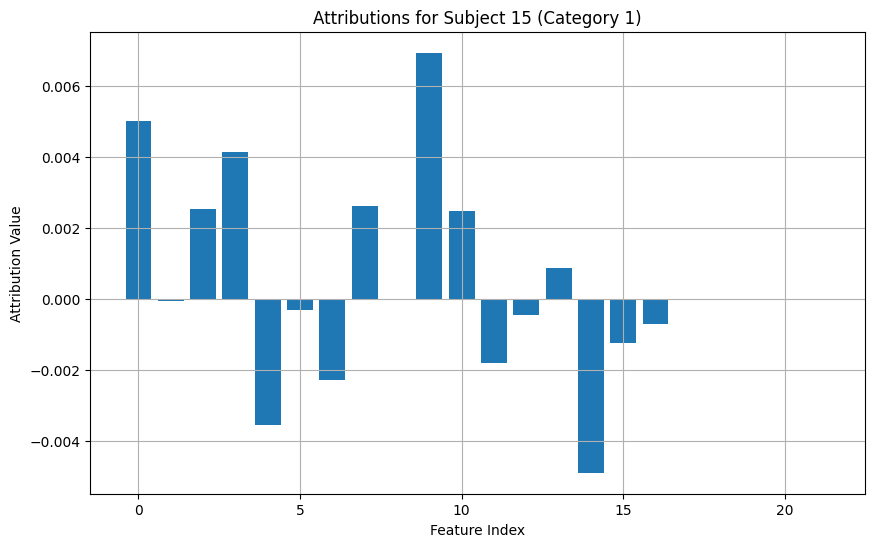

In [ ]:
#load attributions
loaded_duration = 20
loaded_target_index_2 = 1

with open(f'MyData/attributions_{loaded_duration}_{loaded_target_index_2}.pickle', 'rb') as pickle_file:
    my_dict = pickle.load(pickle_file)
    
attributions = my_dict


import matplotlib.pyplot as plt

patient_num = 15

# Assuming attributions[15]['cat'][1][0] is the tensor containing attribution values
attributions_tensor = attributions[patient_num]['cat'][1][0]

# Flatten the tensor
attributions_values = attributions_tensor.squeeze().cpu().numpy()

# Get the indices for the features
feature_indices = range(len(attributions_values))

# Plot the attributions as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(feature_indices, attributions_values)
plt.xlabel('Feature Index')
plt.ylabel('Attribution Value')
plt.title('Attributions for Subject 15 (Category 1)')
plt.grid(True)
plt.savefig(f'MyData/patient_{patient_num}_duration_{loaded_duration}.png')
plt.show()


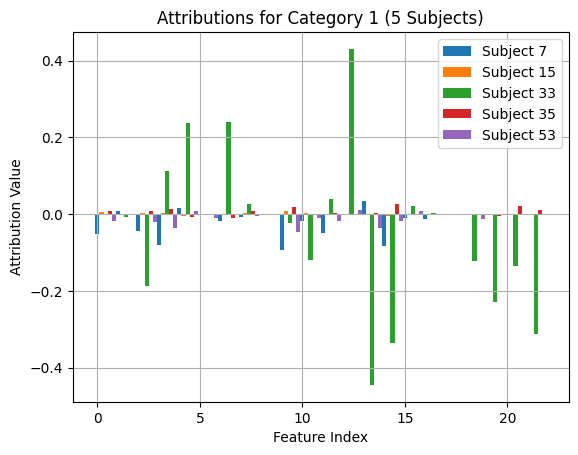

In [ ]:
import matplotlib.pyplot as plt

# Define the number of subjects you want to include in the plot
num_subjects_to_plot = 5  # Set the desired number of subjects here

# Define the width for each bar
bar_width = 0.2

# Iterate over a subset of subjects from the attributions dictionary
for idx, (rid, attr_data) in enumerate(attributions.items()):
    if idx >= num_subjects_to_plot:
        break  # Break the loop once the desired number of subjects is reached

    # Get the attribution tensor for category 1
    attributions_tensor = attr_data['cat'][1][0]
    attributions_values = attributions_tensor.squeeze().cpu().numpy()

    # Calculate the position for each bar
    bar_position = idx * bar_width

    # Convert range object to list and add bar_position
    bar_positions = [x + bar_position for x in range(len(attributions_values))]

    # Plot the attributions as a bar plot
    plt.bar(bar_positions, attributions_values, width=bar_width, label=f'Subject {rid}')

# Add labels and title
plt.xlabel('Feature Index')
plt.ylabel('Attribution Value')
plt.title(f'Attributions for Category 1 ({num_subjects_to_plot} Subjects)')
plt.legend()  # Add a legend to distinguish between subjects
plt.grid(True)
plt.show()


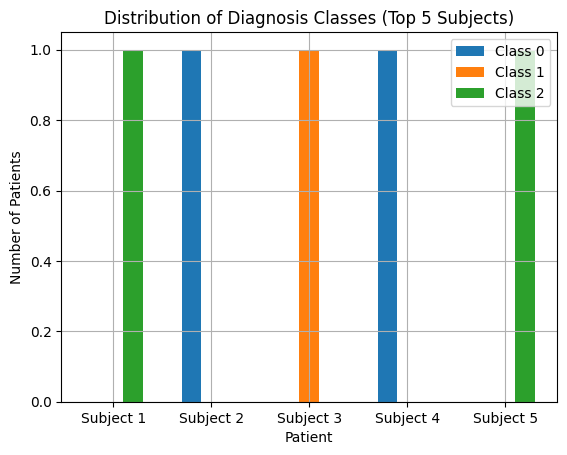

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of subjects you want to include in the plot
num_subjects = 5  # Set the desired number of subjects here

# Define diagnosis classes
diagnosis_classes = ['Class 0', 'Class 1', 'Class 2']

# Initialize counts for each class
class_counts = {diagnosis_class: [0] * num_subjects for diagnosis_class in diagnosis_classes}

# Iterate over a subset of subjects from the attributions dictionary
for idx, (rid, attr_data) in enumerate(attributions.items()):
    if idx >= num_subjects:
        break  # Break the loop once the desired number of subjects is reached

    # Get the attribution tensor for category 1
    attributions_tensor = attr_data['cat'][0][0]
    attributions_values = attributions_tensor.squeeze().cpu().numpy()

    # Determine the diagnosis class
    diagnosis_class = np.argmax(attributions_values)

    # Increment the count for the corresponding class for this subject
    class_counts[diagnosis_classes[diagnosis_class]][idx] += 1

# Plot the counts as a grouped bar plot
bar_width = 0.2
num_classes = len(diagnosis_classes)
for i, (diagnosis_class, counts) in enumerate(class_counts.items()):
    x = np.arange(num_subjects_to_plot) + i * bar_width
    plt.bar(x, counts, width=bar_width, label=diagnosis_class)

# Add labels and title
plt.xlabel('Patient')
plt.ylabel('Number of Patients')
plt.title(f'Distribution of Diagnosis Classes (Top {num_subjects} Subjects)')
plt.xticks(np.arange(num_subjects) + (num_classes - 1) * bar_width / 2, [f'Subject {i}' for i in range(1, num_subjects_to_plot + 1)])
plt.legend()
plt.grid(True)
plt.savefig(f'MyData/{num_subjects}_patient_pred_cat_duration_{duration}.png')
plt.show()
